In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [11]:
DATA_PATH = '../matrix_dataset/'

train_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Train.mat')
test_A_raw = scipy.io.loadmat(DATA_PATH + 'Subject_A_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

train_A_chars = list(train_A_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')

A_train_ds = P300Getter(train_A_raw, eloc, sample_size=72)
A_test_ds = P300Getter(test_A_raw, eloc, sample_size=72, target_chars=test_A_chars)

A_train_ds.get_cnn_p300_dataset(filter=True)
A_test_ds.get_cnn_p300_dataset(filter=True)

#A_train_ds.upsample(4)
#A_test_ds.upsample(2)

X_train_A, y_train_A = A_train_ds.get_data()
X_test_A, y_test_A = A_test_ds.get_data()

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.55it/s]


In [19]:
p300 = np.array(X_train_A[y_train_A.bool()])
non_p300 = np.array(X_train_A[~y_train_A.bool()])

In [39]:
p300.mean(axis=0).shape

(64, 72)

The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA.

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


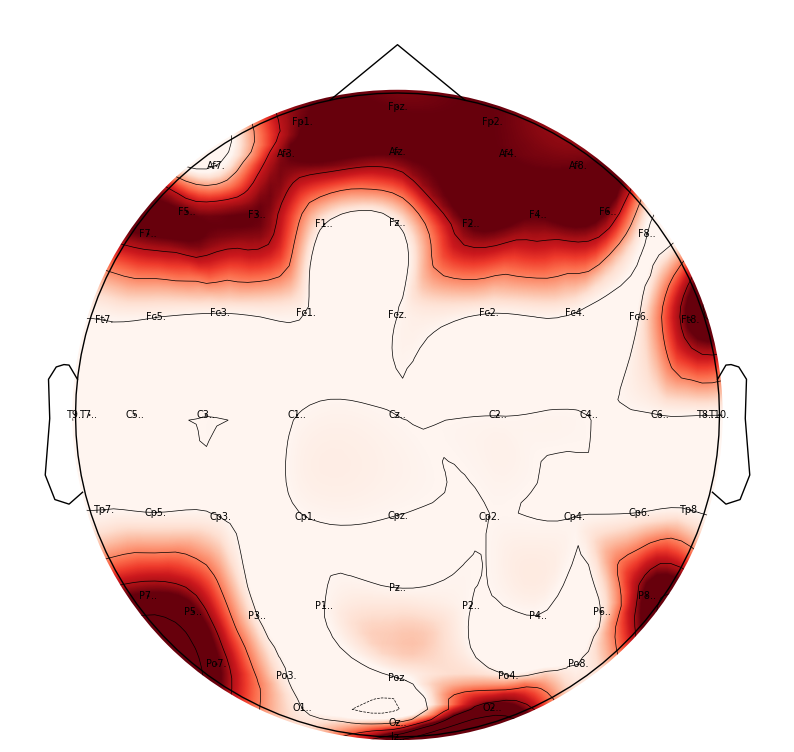

<Figure size 640x480 with 0 Axes>

In [40]:
res = kruskal(p300.mean(axis=0), non_p300.mean(axis=0), axis=1)
mean_res = multipletests(res.pvalue, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)

mne.viz.plot_topomap(mean_res[0], np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, names=eloc.ch_names) 
plt.savefig('figs/electrodes_importance.png')
plt.show()

In [41]:
res = kruskal(p300.mean(axis=0), non_p300.mean(axis=0), axis=0)
mean_res = multipletests(res.pvalue, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)

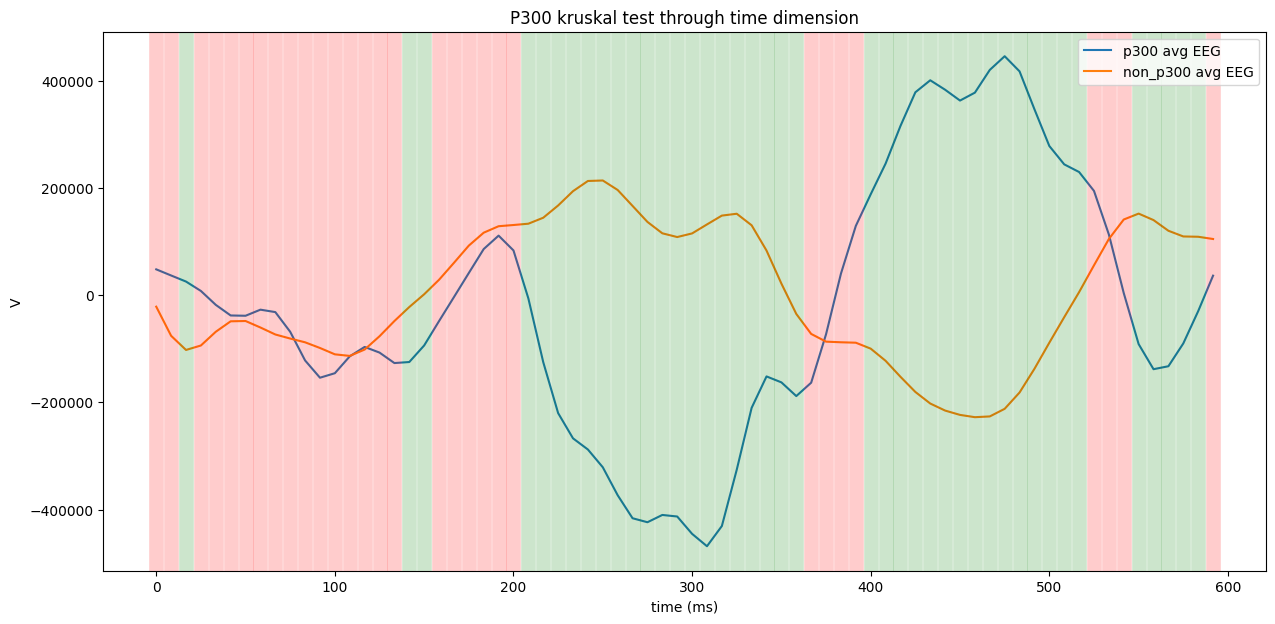

In [42]:
plt.figure(figsize=(15, 7))
t_axis = np.arange(72) / 120 * 1000
plt.plot(t_axis, p300.mean(axis=(0, 1)), label='p300 avg EEG')
plt.plot(t_axis, non_p300.mean(axis=(0, 1)), label='non_p300 avg EEG')

for i in range(0, 72):
    if mean_res[0][i] == 0:
        plt.axvline(t_axis[i], c='r', alpha=0.2, linewidth=10.5)
    else:
        plt.axvline(t_axis[i], c='g', alpha=0.2, linewidth=10.5)
        
plt.legend()
plt.ylabel('V')
plt.xlabel('time (ms)')
plt.title('P300 kruskal test through time dimension')
plt.savefig('figs/time_importance.png')
plt.show()

In [23]:
gnn_weights = np.load('weights/gnn_linear_sum.npy')
cnn_weights = np.load('weights/cnn_linear_sum.npy')

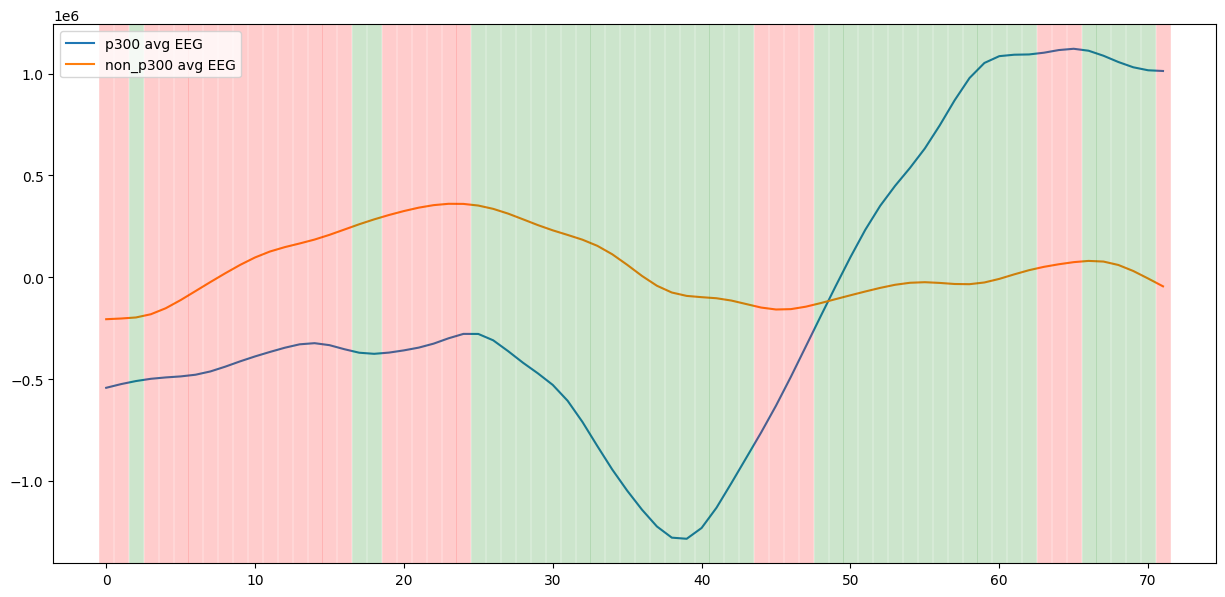

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(cnn_weights @ p300.mean(axis=0), label='p300 avg EEG')
plt.plot(cnn_weights @ non_p300.mean(axis=0), label='non_p300 avg EEG')

for i in range(0, 72):
    if mean_res[0][i] == 0:
        plt.axvline(i, c='r', alpha=0.2, linewidth=10.5)
    else:
        plt.axvline(i, c='g', alpha=0.2, linewidth=10.5)
        
plt.legend()
plt.savefig('figs/time_importance_weight.png')
plt.show()

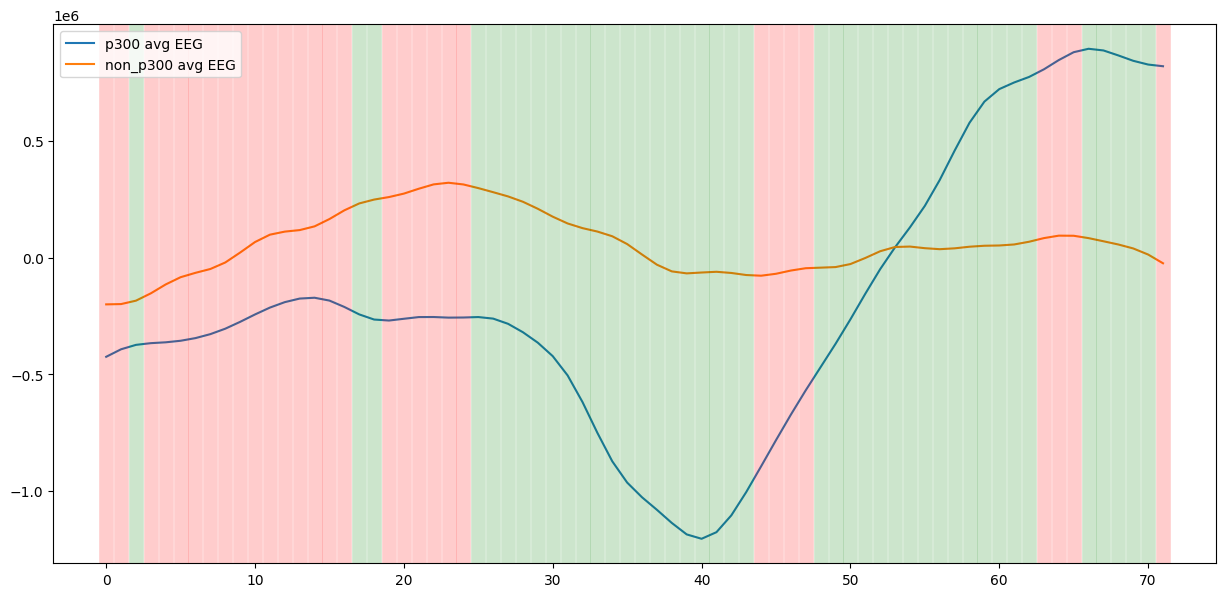

In [25]:
plt.figure(figsize=(15, 7))
plt.plot((gnn_weights @ p300).mean(axis=0), label='p300 avg EEG')
plt.plot((gnn_weights @ non_p300).mean(axis=0), label='non_p300 avg EEG')

for i in range(0, 72):
    if mean_res[0][i] == 0:
        plt.axvline(i, c='r', alpha=0.2, linewidth=10.5)
    else:
        plt.axvline(i, c='g', alpha=0.2, linewidth=10.5)
        
plt.legend()
plt.show()

In [26]:
cnn_weights.shape

(64,)

In [27]:
cnn_weights.reshape((1, -1, 1)).shape

(1, 64, 1)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


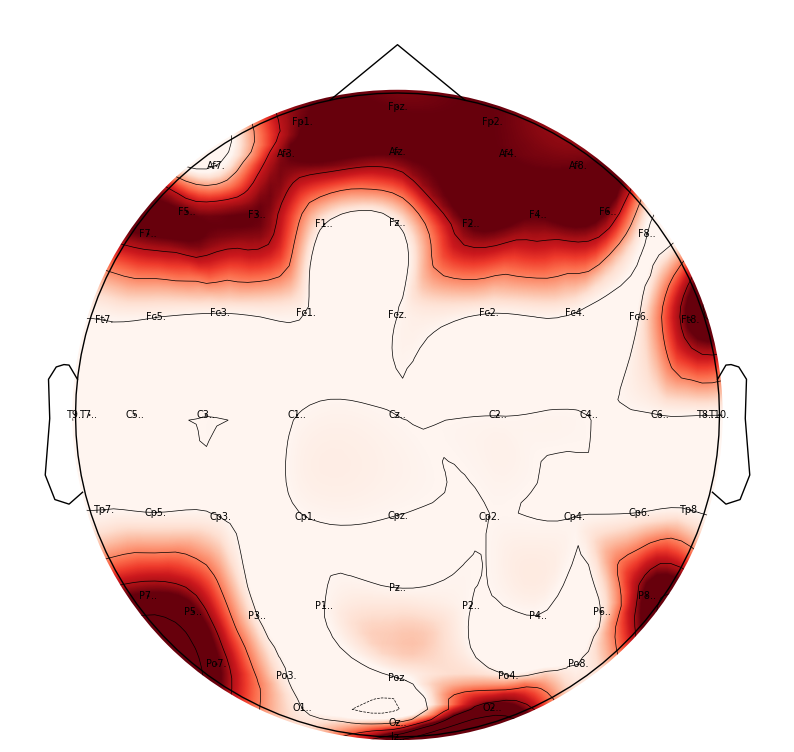

<Figure size 640x480 with 0 Axes>

In [43]:
res = kruskal((p300 * gnn_weights.reshape((1, -1, 1))).mean(axis=0), (non_p300 * gnn_weights.reshape((1, -1, 1))).mean(axis=0), axis=1)
mean_res = multipletests(res.pvalue, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)

mne.viz.plot_topomap(mean_res[0], np.stack(eloc.get_positions()['ch_pos'].values())[:,:-1], size=10, names=eloc.ch_names) 
plt.savefig('figs/electrodes_importance_weight.png')
plt.show()

In [44]:
res = kruskal((p300 * gnn_weights.reshape((1, -1, 1))).mean(axis=0), (non_p300 * gnn_weights.reshape((1, -1, 1))).mean(axis=0), axis=0)
mean_res = multipletests(res.pvalue, alpha=0.05, method='holm', is_sorted=False, returnsorted=False)

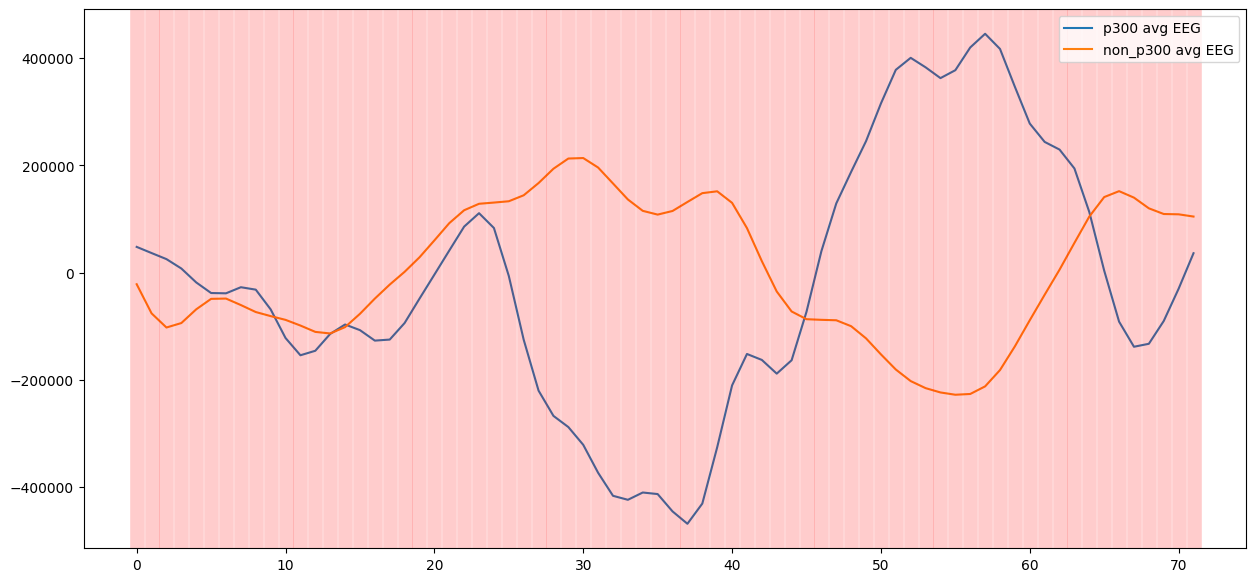

In [45]:
plt.figure(figsize=(15, 7))
plt.plot(p300.mean(axis=(0, 1)), label='p300 avg EEG')
plt.plot(non_p300.mean(axis=(0, 1)), label='non_p300 avg EEG')

for i in range(0, 72):
    if mean_res[0][i] == 0:
        plt.axvline(i, c='r', alpha=0.2, linewidth=10.5)
    else:
        plt.axvline(i, c='g', alpha=0.2, linewidth=10.5)
        
plt.legend()
plt.show()

In [ ]:
cnn_weights @ output

In [24]:
train_A_dataset = CNNMatrixDataset(tensors=(X_train_A, y_train_A), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(X_test_A, y_test_A), with_target=True, transform=None)

batch_size = 1024 #256

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

In [54]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, count_parameters
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph

In [128]:
DATA_PATH = '../matrix_dataset/'

train_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Train.mat')
test_B_raw = scipy.io.loadmat(DATA_PATH + 'Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage(DATA_PATH + 'eloc64.loc')
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

In [129]:
train_B_chars = list(train_B_raw['TargetChar'][0])
test_B_chars = list('MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR')

In [130]:
B_train_ds = P300Getter(train_B_raw, eloc)
B_test_ds = P300Getter(test_B_raw, eloc, target_chars=test_B_chars)

B_train_ds.get_cnn_p300_dataset(filter=True)
B_test_ds.get_cnn_p300_dataset(filter=True)
B_train_ds.upsample(4)

100%|█████████████████████████████████████████| 100/100 [00:04<00:00, 20.61it/s]


In [131]:
X_train_B, y_train_B = B_train_ds.get_data()
X_test_B, y_test_B = B_test_ds.get_data()

In [132]:
train_B_dataset = CNNMatrixDataset(tensors=(X_train_B, y_train_B), with_target=True, transform=None)
test_B_dataset = CNNMatrixDataset(tensors=(X_test_B, y_test_B), with_target=True, transform=None)

batch_size = 1024 #256

train_B_CNN = DataLoader(train_B_dataset, batch_size=batch_size) # , shuffle=True
test_B_CNN = DataLoader(test_B_dataset, batch_size=batch_size) # , shuffle=True

data_loaders_CNN_B = {'train':train_B_CNN, 'val':test_B_CNN}